# Import

In [1]:
import numpy as np
from timeit import default_timer as time
from matplotlib import pyplot as plt
from numpy.linalg import inv
import functions_eq_mag as fc
import functions_fatiando as ft
%matplotlib inline

# Observation and Equivalent layer grids

In [2]:
# Create a regular grid at 0m height
area = [-5000., 5000., -4000., 4000.]
shape = (100, 50)
N = shape[0]*shape[1]
xi, yi, zi = ft.gridder_regular(area, shape, z=-900.)
x_perc = (xi[shape[1]]-xi[0])*0.5
y_perc = (yi[1]-yi[0])*0.5
np.random.seed(10)
noise_x = np.random.normal(0, x_perc, len(xi))
noise_y = np.random.normal(0, y_perc, len(xi))
xi = xi + noise_x
yi = yi + noise_y
xi_plot, yi_plot, = xi/1000, yi/1000
#xi = ft.utils_contaminate(xi, 5, seed=0, percent=True)
#yi = ft.utils_contaminate(yi, 50, seed=2, percent=True)
#zi = utils.contaminate(zi, 0.08, seed=3, percent=True)

# Equivalent Layer
areaj = [-5000., 5000., -4000., 4000.]
shapej = (100, 50)
Nj = shapej[0]*shapej[1]
xj, yj, zj = ft.gridder_regular(areaj, shapej, z=50)

# Model
verts1 = [[2000, -3000], [4000, -3000], [4000, 1000], [2000, 1000]]
verts2 = [[-2000, 2000], [0, 2000], [0, 6000], [-2000, 6000]]
model_prism = [ft.mesher_PolygonalPrism(verts1, 900., 1500., props={'magnetization':[2,2,0]}),
               ft.mesher_PolygonalPrism(verts2, 700., 1100., props={'magnetization':[2,2,0]})]

R = 1000 #Radius
xc, yc, zc = -3000.,-2000.,2000. #Center of sphere
model_sphere = [ft.mesher_Sphere(xc, yc, zc, R, props={'magnetization':[2,2,0]})]

In [3]:
# Magnetic Configuration
inc0 = np.deg2rad(15.)
dec0 = np.deg2rad(50.)
inc = np.deg2rad(15.)
dec = np.deg2rad(50.)

F = np.array([np.cos(inc0)*np.cos(dec0), np.cos(inc0)*np.sin(dec0), np.sin(inc0)])
h = np.array([np.cos(inc)*np.cos(dec), np.cos(inc)*np.sin(dec), np.sin(inc)])

In [4]:
tf_prism = ft.polyprism_tf(xi, yi, zi, model_prism, np.rad2deg(inc0), np.rad2deg(dec0))
tf_sphere = ft.sphere_tf(xi, yi, zi, model_sphere, np.rad2deg(inc0), np.rad2deg(dec0))
tf = tf_prism + tf_sphere
tf = ft.utils_contaminate(tf, 0.5, seed=0, percent=False)

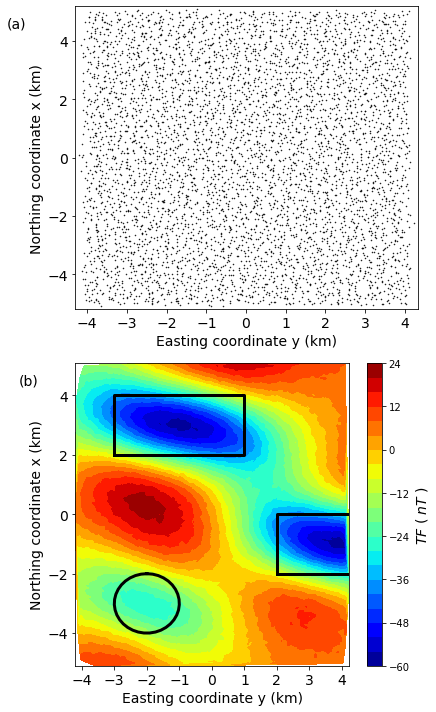

In [5]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc/1000 + R/1000*np.cos(phi)
y = yc/1000 + R/1000*np.sin(phi)

x_p = [-3., -3, 1, 1, -3.]
y_p = [2., 4, 4, 2, 2.]

x_p2 = [2, 2, 6, 6, 2]
y_p2 = [-2, 0, 0, -2, -2.]

fig = plt.figure(figsize=(6,10))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(211)
plt.title('(a)', y=0.91, x=-0.17, fontsize=14)
plt.plot(yi_plot, xi_plot, 'ko', alpha=1, ms=0.5)
plt.xlim(np.min(yi_plot)-0.1,np.max(yi_plot)+0.1)
plt.ylim(np.min(xi_plot)-0.1,np.max(xi_plot)+0.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(212)
plt.title('(b)', y=0.91, x=-0.17, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
#plt.plot(yi, xi, 'ko-', alpha=0.1)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
plt.savefig('figures/model_mag_synthetic_irregular_50.png', dpi=300)

### Classic Forward Problem Construction - MAG

In [6]:
# Calculo da matriz de sensibilidade
s = time()
p_c, tf_c = fc.classic_mag(xi,yi,zi,zj,F,h,N,tf)
e = time()
tcpu = e - s
print (tcpu)

8.238152100000036


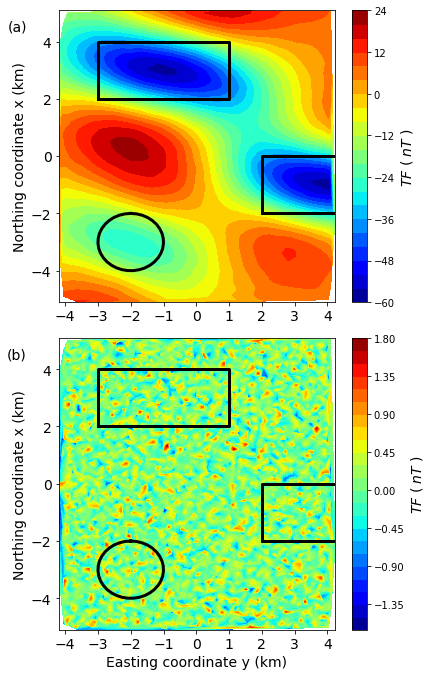

In [7]:
fig = plt.figure(figsize=(6,9.5))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(211)
plt.title('(a)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_c,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

delta_tf = tf-tf_c
plt.subplot(212)
plt.title('(b)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
plt.savefig('figures/predicted_synthetic_mag_irregular_50.png', dpi=300)

In [8]:
mean = np.mean(delta_tf)
print (mean)
std = np.std(delta_tf)
print (std)

-0.0007132797380980442
0.4557436736585623


## Parameter Plot

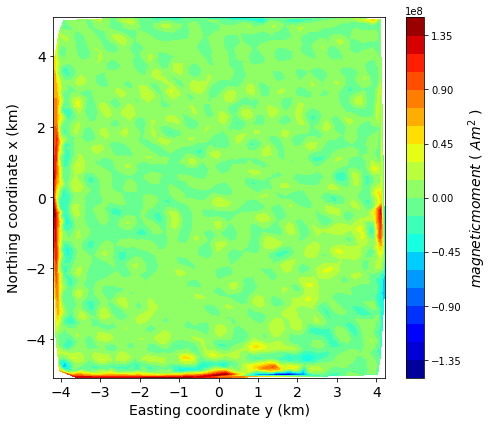

In [9]:
fig = plt.figure(figsize=(7,6))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot, p_c,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
plt.savefig('figures/classic_fastirregular_50.png', dpi=300)

# Conjugate Gradient Least Square

### BCCB  matrix-vector product with Linear CGLS implementation - no conditioning

In [10]:
w = time()
itmax = 50
p_cgls,dobs_cgls = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,tf,F,h,itmax)
t = time()
tcpu = t - w
print (tcpu)

0.2135789000000159


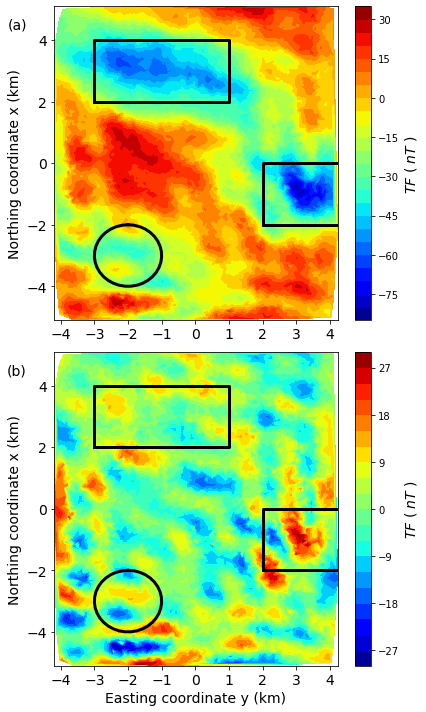

In [11]:
fig = plt.figure(figsize=(6,10))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(211)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,dobs_cgls,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

delta_tf2 = tf-dobs_cgls
plt.subplot(212)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf2,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
plt.savefig('figures/predicted_bccb_mag_irregular_50.png', dpi=300)

In [12]:
mean = np.mean(delta_tf2)
print (mean)
std = np.std(delta_tf2)
print (std)

0.22843620806763776
7.8632173608108555


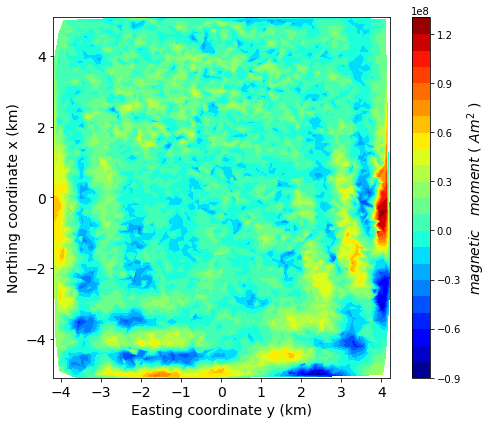

In [13]:
fig = plt.figure(figsize=(7,6))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,p_cgls,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic \quad moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
plt.savefig('figures/p_fast_irregular_50.png', dpi=300)

## CGLS Convergence

In [5]:
itmax = np.arange(1,80,1)
res_list_ls = []
for k in itmax:
    p_cgls,dobs_cgls = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,tf,F,h,k)
    norm_res_ls = np.linalg.norm(tf-dobs_cgls)
    res_list_ls.append(norm_res_ls)

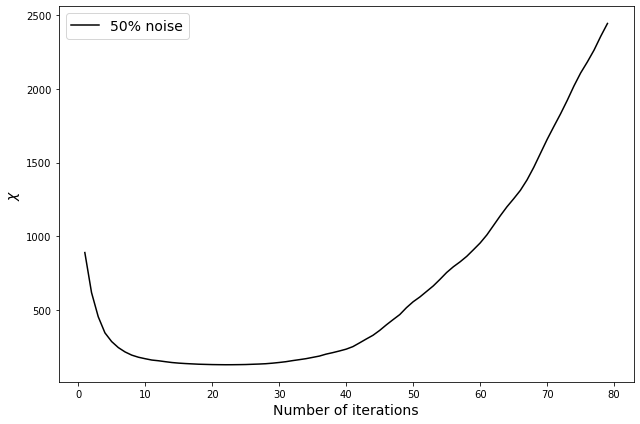

In [6]:
fig = plt.figure(figsize=(9,6))
fig.patch.set_facecolor('xkcd:white')
plt.plot(itmax,res_list_ls, 'k-', label='50% noise')
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('$\chi$', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.tight_layout();
plt.savefig('figures/convergence_synthetic_mag_irregular_50.png', dpi=300)

In [16]:
print (x_perc)
print (y_perc)

50.50505050505035
81.63265306122457
